<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_function_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Task Solving with Provided Tools as Functions

AutoGen offers conversable agents powered by LLM, tool, or human, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participation through multi-agent conversation. Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to make function calls with the new feature of OpenAI models (in model version 0613). A specified prompt and function configs must be passed to `AssistantAgent` to initialize the agent. The corresponding functions must be passed to `UserProxyAgent`, which will execute any function calls made by `AssistantAgent`. Besides this requirement of matching descriptions with functions, we recommend checking the system message in the `AssistantAgent` to ensure the instructions align with the function call descriptions.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install the [mathchat] option since we will import functions from `MathUserProxyAgent`:
```bash
pip install "pyautogen[mathchat]"
```

In [1]:
# %pip install "pyautogen[mathchat]~=0.1.0"

## Set your API Endpoint

The [`config_list_from_models`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_models) function tries to create a list of configurations using Azure OpenAI endpoints and OpenAI endpoints for the provided list of models. It assumes the api keys and api bases are stored in the corresponding environment variables or local txt files:

- OpenAI API key: os.environ["OPENAI_API_KEY"] or `openai_api_key_file="key_openai.txt"`.
- Azure OpenAI API key: os.environ["AZURE_OPENAI_API_KEY"] or `aoai_api_key_file="key_aoai.txt"`. Multiple keys can be stored, one per line.
- Azure OpenAI API base: os.environ["AZURE_OPENAI_API_BASE"] or `aoai_api_base_file="base_aoai.txt"`. Multiple bases can be stored, one per line.

It's OK to have only the OpenAI API key, or only the Azure OpenAI API key + base.
If you open this notebook in google colab, you can upload your files by clicking the file icon on the left panel and then choosing "upload file" icon.

The following code excludes Azure OpenAI endpoints from the config list because some endpoints don't support functions yet. Remove the `exclude` argument if they do.

In [2]:
import autogen

config_list = autogen.config_list_from_models(model_list=["gpt-4", "gpt-3.5-turbo", "gpt-3.5-turbo-16k"], exclude="aoai")

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },  # OpenAI API endpoint for gpt-4
    {
        'model': 'gpt-3.5-turbo',
        'api_key': '<your OpenAI API key here>',
    },  # OpenAI API endpoint for gpt-3.5-turbo
    {
        'model': 'gpt-3.5-turbo-16k',
        'api_key': '<your OpenAI API key here>',
    },  # OpenAI API endpoint for gpt-3.5-turbo-16k
]
```


In [3]:
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '34816af78fea4f4a9c9ee3d0eead7b81',
        'api_base': 'https://openai-zq1.openai.azure.com/',
        'api_type': 'azure',
        'api_version': '2023-07-01-preview',
    },
    {
        'model': 'gpt-35-turbo',
        'api_key': '34816af78fea4f4a9c9ee3d0eead7b81',
        'api_base': 'https://openai-zq1.openai.azure.com/',
        'api_type': 'azure',
        'api_version': '2023-07-01-preview',
    },
]

## Making Function Calls

In this example, we demonstrate function call execution with `AssistantAgent` and `UserProxyAgent`. With the default system prompt of `AssistantAgent`, we allow the LLM assistant to perform tasks with code, and the `UserProxyAgent` would extract code blocks from the LLM response and execute them. With the new "function_call" feature, we define functions and specify the description of the function in the OpenAI config for the `AssistantAgent`. Then we register the functions in `UserProxyAgent`.


user_proxy (to chatbot):

Draw two agents chatting with each other with an example dialog. Don't add plt.show().

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: python *****
Arguments: 
{
  "cell": "import matplotlib.pyplot as plt\nimport numpy as np\n\nfig, ax = plt.subplots()\n\n# Agent 1\nagent1 = plt.Circle((0.2, 0.4), 0.1, color='b')\nax.add_artist(agent1)\nax.text(0.2, 0.4, 'A1', color='white', ha='center', va='center')\nplt.annotate('hi there!', (0.2, 0.5), xytext=(0.3, 0.6),\n             arrowprops=dict(facecolor='black', shrink=0.05), ha='center')\n\n# Agent 2\nagent2 = plt.Circle((0.6, 0.4), 0.1, color='r')\nax.add_artist(agent2)\nax.text(0.6, 0.4, 'A2', color='white', ha='center', va='center')\nplt.annotate('hello!', (0.6, 0.5), xytext=(0.5, 0.6),\n             arrowprops=dict(facecolor='black', shrink=0.05), ha='center')\n\nplt.xlim(0,1)\nplt.ylim(0,1)\nplt.gca().set_aspect('equal', 

(0.0, 1.0, 0.0, 1.0)

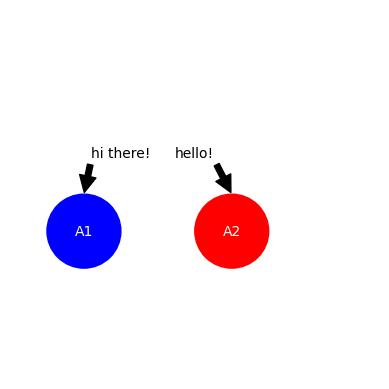

user_proxy (to chatbot):

***** Response from calling function "python" *****
(0.0, 1.0, 0.0, 1.0)
***************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [4]:
llm_config = {
    "functions": [
        {
            "name": "python",
            "description": "run cell in ipython and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "cell": {
                        "type": "string",
                        "description": "Valid Python cell to execute.",
                    }
                },
                "required": ["cell"],
            },
        },
        {
            "name": "sh",
            "description": "run a shell script and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "script": {
                        "type": "string",
                        "description": "Valid shell script to execute.",
                    }
                },
                "required": ["script"],
            },
        },
    ],
    "config_list": config_list,
    "request_timeout": 120,
}
chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="For coding tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={"work_dir": "coding"},
)

# define functions according to the function description
from IPython import get_ipython

def exec_python(cell):
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log

def exec_sh(script):
    return user_proxy.execute_code_blocks([("sh", script)])

# register the functions
user_proxy.register_function(
    function_map={
        "python": exec_python,
        "sh": exec_sh,
    }
)

# start the conversation
user_proxy.initiate_chat(
    chatbot,
    message="Draw two agents chatting with each other with an example dialog. Don't add plt.show().",
)


## Another example with Wolfram Alpha API

We give another example of querying Wolfram Alpha API to solve math problem. We use the predefined function `MathUserProxyAgent().execute_one_wolfram_query` as the function to be called.

In [5]:
import os
from autogen.agentchat.contrib.math_user_proxy_agent import MathUserProxyAgent

# you need to provide a wolfram alpha app id to run this example
if not os.environ.get("WOLFRAM_ALPHA_APPID"):
    os.environ["WOLFRAM_ALPHA_APPID"] = open("wolfram.txt").read().strip()

llm_config = {
    "model": "gpt-4-0613",
    "functions": [
        {
            "name": "query_wolfram",
            "description": "Return the API query result from the Wolfram Alpha. the return is a tuple of (result, is_success).",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The Wolfram Alpha code to be executed.",
                    }
                },
                "required": ["query"],
            },
        }
    ],
    "config_list": config_list,
}
chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="Only use the functions you have been provided with. Do not ask the user to perform other actions than executing the functions. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

# the key in `function_map` should match the function name in "functions" above
# we register a class instance method directly
user_proxy = autogen.UserProxyAgent(
    "user_proxy",
    max_consecutive_auto_reply=2,
    human_input_mode="NEVER",
    function_map={"query_wolfram": MathUserProxyAgent().execute_one_wolfram_query},
)

# start the conversation
user_proxy.initiate_chat(
    chatbot,
    message="Problem: Find all $x$ that satisfy the inequality $(2x+10)(x+3)<(3x+9)(x+8)$. Express your answer in interval notation.",
)


FileNotFoundError: [Errno 2] No such file or directory: 'wolfram.txt'